In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import json

from scipy.special import rel_entr
import emoji
import re
import html

from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

from wordcloud import WordCloud, STOPWORDS




In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### load data

In [5]:
train = pd.read_csv("Corona_NLP_train.csv", encoding='latin-1')
test = pd.read_csv("Corona_NLP_test.csv", encoding='latin-1')


In [6]:
train.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive


In [7]:
test.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1",Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive


In [8]:
print("Dataset shapes:")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

Dataset shapes:
Train: (41157, 6)
Test: (3798, 6)


### union Train and Test

In [9]:
combined_df = pd.concat([train, test], ignore_index=True)

#### data types conversion

In [10]:
print(combined_df.dtypes)

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object


In [11]:
# Convert Tweetat to datetime
combined_df['TweetAt'] = pd.to_datetime(combined_df['TweetAt'], format='%d-%m-%Y')
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')
test['TweetAt'] = pd.to_datetime(test['TweetAt'], format='%d-%m-%Y')

#### missing values

In [12]:
#check for missing values
missing_count = combined_df.isnull().sum()
print("missing values:")
print(missing_count)

missing values:
UserName            0
ScreenName          0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [13]:
##check if the missing values are both in test and train
missing_count_train = train.Location.isnull().sum()
missing_percentage_train  = (train.Location.isnull().sum() / len(train.Location)) * 100
print("missing locations train:")
print("count - " + str(missing_count_train))
print("rate - " + str(missing_percentage_train))
missing_count_test = test.Location.isnull().sum()
missing_percentage_test  = (test.Location.isnull().sum() / len(test.Location)) * 100
print("missing locations test:")
print("count - " + str(missing_count_test))
print("rate - " + str(missing_percentage_test))

missing locations train:
count - 8590
rate - 20.87129771363316
missing locations test:
count - 834
rate - 21.958925750394943


**only location has missing values. will be handled later when analyzing the location column.

#### duplicates

In [14]:
# Check if any full rows are duplicated
duplicates = combined_df[combined_df.duplicated()]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

Number of duplicate rows: 0


#### general statistics

In [15]:
num_users = combined_df['UserName'].nunique()
print(f"Unique users: {num_users}")
tweets_per_user = combined_df['UserName'].value_counts()
print(f"Avg tweets per user: {tweets_per_user.mean():.2f}")
print(f"Median tweets per user: {tweets_per_user.median():.2f}")

num_screens = combined_df['ScreenName'].nunique()
print(f"\nUnique screens: {num_screens}")
tweets_per_screen= combined_df['ScreenName'].value_counts()
print(f"Avg tweets per screen: {tweets_per_screen.mean():.2f}")
print(f"Median tweets per screen: {tweets_per_screen.median():.2f}")

num_locations = combined_df['Location'].nunique()
print(f"\nUnique locations: {num_locations}")
top_locations = combined_df['Location'].value_counts().head(10)
print("Top 10 locations:")
print(top_locations)

# tweets_per_day = combined_df['TweetAt'].dt.date.value_counts().sort_index()
# print(tweets_per_day.head())

# sentiment_dist = combined_df['Sentiment'].value_counts(normalize=True) * 100
# print("Sentiment distribution (%):")
# print(sentiment_dist.round(2))

Unique users: 44955
Avg tweets per user: 1.00
Median tweets per user: 1.00

Unique screens: 44955
Avg tweets per screen: 1.00
Median tweets per screen: 1.00

Unique locations: 13127
Top 10 locations:
United States      603
London, England    568
London             565
New York, NY       429
Washington, DC     411
United Kingdom     355
Los Angeles, CA    314
India              283
UK                 246
USA                243
Name: Location, dtype: int64


### User column analysis

In [16]:
num_users = combined_df['UserName'].nunique()
print(f"Unique users: {num_users}")
tweets_per_user = combined_df['UserName'].value_counts()
print(f"Avg tweets per user: {tweets_per_user.mean():.2f}")
print(f"Median tweets per user: {tweets_per_user.median():.2f}")

Unique users: 44955
Avg tweets per user: 1.00
Median tweets per user: 1.00


### Screen column analysis

In [17]:
num_screens = combined_df['ScreenName'].nunique()
print(f"\nUnique screens: {num_screens}")
tweets_per_screen= combined_df['ScreenName'].value_counts()
print(f"Avg tweets per screen: {tweets_per_screen.mean():.2f}")
print(f"Median tweets per screen: {tweets_per_screen.median():.2f}")


Unique screens: 44955
Avg tweets per screen: 1.00
Median tweets per screen: 1.00


### Location column analysis

In [18]:
#impute null values with "Unknown"
combined_df['Location'] = combined_df['Location'].fillna('Unknown')
train['Location'] = train['Location'].fillna('Unknown')
test['Location'] = test['Location'].fillna('Unknown')


In [19]:
num_locations = combined_df['Location'].nunique()
print(f"\nUnique locations: {num_locations}")
top_locations = combined_df['Location'].value_counts().head(10)
print("Top 10 locations:")
print(top_locations)


Unique locations: 13127
Top 10 locations:
Unknown            9427
United States       603
London, England     568
London              565
New York, NY        429
Washington, DC      411
United Kingdom      355
Los Angeles, CA     314
India               283
UK                  246
Name: Location, dtype: int64


#### Location Standartization

In [20]:
## map location to a standardized form (country) using a dictionary which was created in advance using the Google Maps Geocodin API
## dictionary creation code in the "location_cache_creation.py" file
## there are new null values after this step (values that could not be mapped to anything) and the are also imputed with "unknown"

with open('location_cache.json', 'r', encoding='utf-8') as f:
    location_dict = json.load(f)

location_map = {k: v['long_name'] for k, v in location_dict.items() if 'long_name' in v and v['long_name'] != "N/A"}
combined_df['Location_standardized'] = combined_df['Location'].map(location_map)
combined_df['Location_standardized'] = combined_df['Location_standardized'].fillna("unknown")

train['Location_standardized'] = train['Location'].map(location_map)
train['Location_standardized'] = train['Location_standardized'].fillna("unknown")

test['Location_standardized'] = test['Location'].map(location_map)
test['Location_standardized'] = test['Location_standardized'].fillna("unknown")


In [21]:
#rerun statistics after standartization
num_locations = combined_df['Location_standardized'].nunique()
print(f"\nUnique locations: {num_locations}")
top_locations = combined_df['Location_standardized'].value_counts().head(10)
print("Top 10 locations:")
print(top_locations)


Unique locations: 176
Top 10 locations:
unknown           15710
United States     13898
United Kingdom     5762
Canada             1956
India              1589
Australia          1144
South Africa        381
Nigeria             369
Ireland             241
New Zealand         229
Name: Location_standardized, dtype: int64


In [22]:
## sentiment distribution over location to check Locatoion-Sentiment correlation

# Group by Location_standardized and Sentiment
location_sentiment_counts = combined_df.groupby(['Location_standardized', 'Sentiment']).size().unstack(fill_value=0)

#Normalize by total tweets per country
location_sentiment_pct = location_sentiment_counts.div(location_sentiment_counts.sum(axis=1), axis=0)

# Total tweet count per country (across all sentiments)
total_tweets = location_sentiment_counts.sum(axis=1)

# Add to percentage DataFrame
location_sentiment_pct_total = location_sentiment_pct.copy()
location_sentiment_pct_total['total_tweets'] = total_tweets

# show top 10 tweeted locations
location_sentiment_pct_total.sort_values('total_tweets', ascending=False).head(10)


Sentiment,Extremely Negative,Extremely Positive,Negative,Neutral,Positive,total_tweets
Location_standardized,,,,,,
unknown,0.147040,0.153024,0.254424,0.179440,0.266073,15710
United States,0.115916,0.171967,0.229170,0.193697,0.289250,13898
United Kingdom,0.161402,0.162444,0.241756,0.166262,0.268136,5762
Canada,0.110429,0.175358,0.250000,0.186094,0.278119,1956
India,0.116425,0.172435,0.252989,0.191315,0.266834,1589
Australia,0.149476,0.143357,0.243007,0.183566,0.280594,1144
South Africa,0.144357,0.139108,0.257218,0.178478,0.280840,381
Nigeria,0.121951,0.195122,0.238482,0.168022,0.276423,369
Ireland,0.095436,0.178423,0.199170,0.224066,0.302905,241


In [23]:
## check if there any location whose sentiment distribution significantly deviates from the global sentiment distribution
location_sentiment_pct = location_sentiment_pct[location_sentiment_counts.sum(axis=1)>50]
eps = 1e-6
location_sentiment_pct = location_sentiment_pct.fillna(0)+eps

global_dist = location_sentiment_counts.sum().div(location_sentiment_counts.sum().sum())
global_dist = global_dist+eps
global_dist /= global_dist.sum()


kl_divergence = location_sentiment_pct.apply(lambda row: sum(rel_entr(row, global_dist)), axis=1)

mean_kl = kl_divergence.mean()
std_kl = kl_divergence.std()

# Locations with KL more than 1 std above mean
unusual_locs = kl_divergence[kl_divergence > (mean_kl + 2*std_kl)].sort_values(ascending=False)
unusual_locs

Location_standardized
China    0.070232
Ghana    0.056462
dtype: float64

In [24]:
location_sentiment_pct_total.loc[['China','Ghana']]

Sentiment,Extremely Negative,Extremely Positive,Negative,Neutral,Positive,total_tweets
Location_standardized,,,,,,
China,0.031915,0.148936,0.319149,0.191489,0.308511,94
Ghana,0.081395,0.255814,0.186047,0.139535,0.337209,86


### Tweets trend over time

#### weekly resolution

<Figure size 1200x700 with 0 Axes>

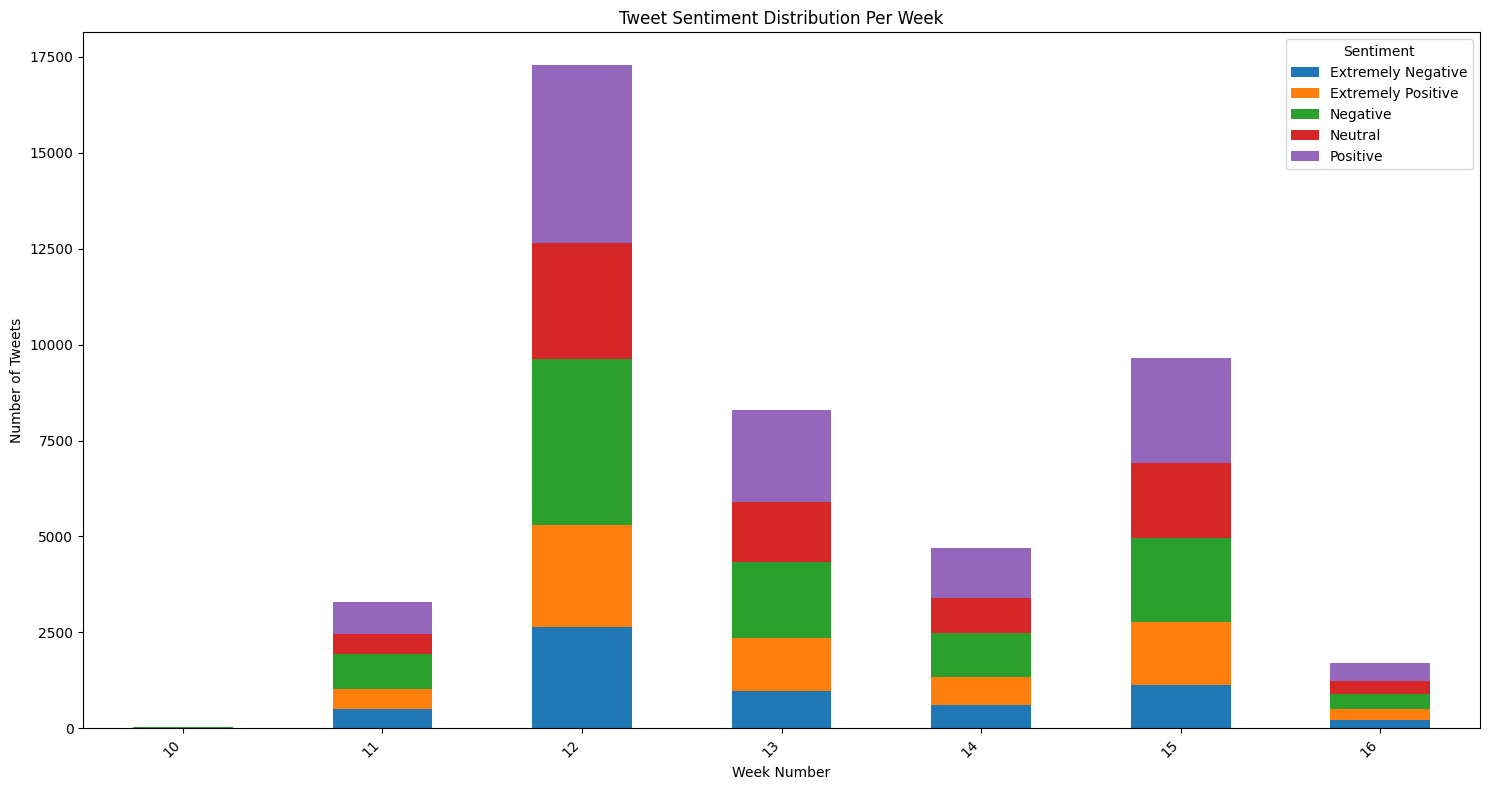

In [25]:

# Extract the week number
temp_df = combined_df.copy()
temp_df['Week'] = temp_df['TweetAt'].dt.isocalendar().week

# Count tweets for each sentiment per week
sentiment_counts_per_week = temp_df.groupby(['Week', 'Sentiment']).size().unstack(fill_value=0)

# Plot the distribution
plt.figure(figsize=(12, 7))
sentiment_counts_per_week.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Tweet Sentiment Distribution Per Week')
plt.xlabel('Week Number')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

<Figure size 1200x700 with 0 Axes>

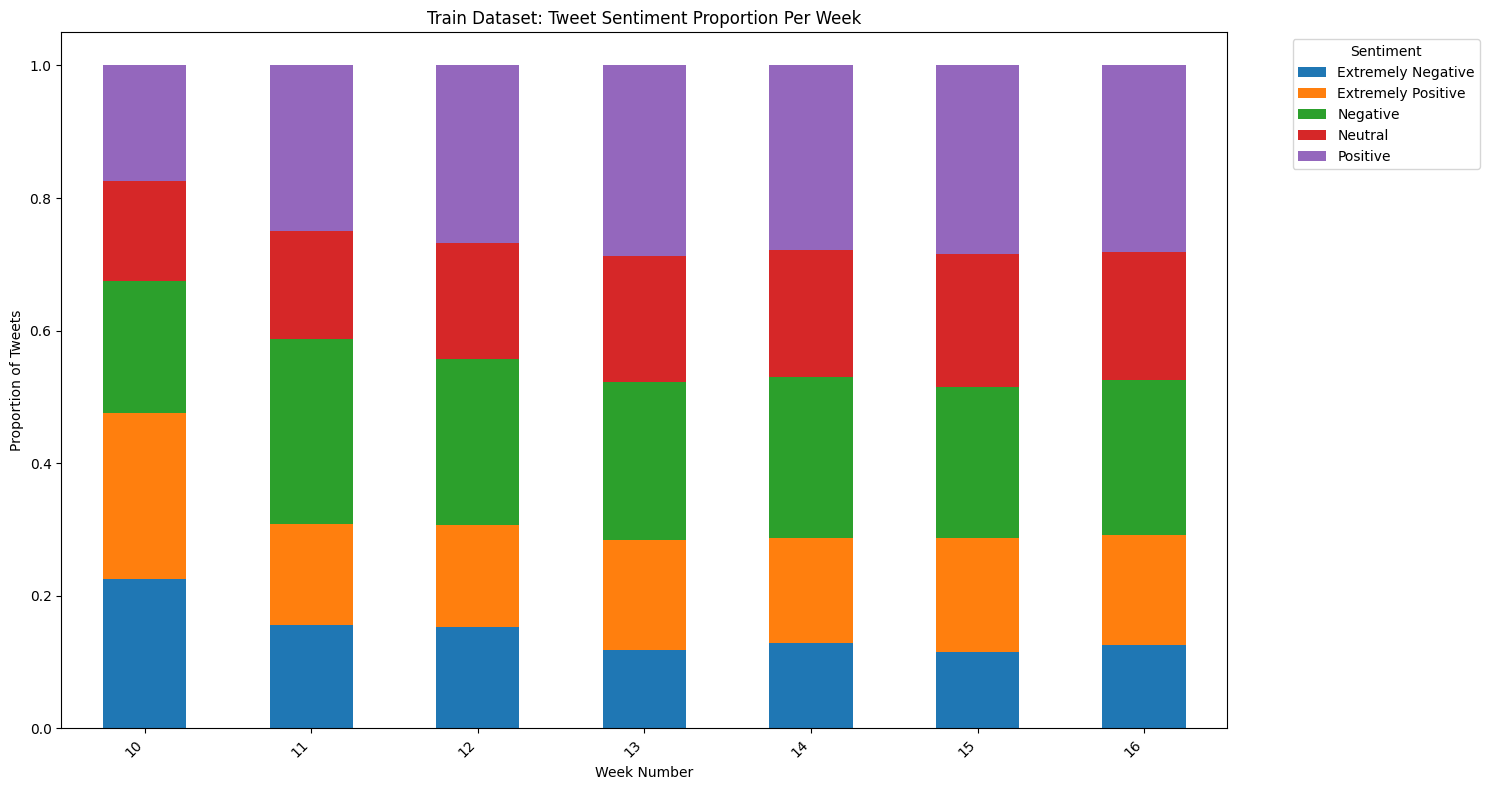

In [26]:
def plot_sentiment_proportions(df, title):
    # Calculates and plots the weekly proportion of each sentiment.
    # Extract the week number

    # Count tweets for each sentiment per week
    sentiment_counts_per_week = df.groupby(['Week', 'Sentiment']).size().unstack(fill_value=0)

    # Calculate proportions
    sentiment_proportions_per_week = sentiment_counts_per_week.div(sentiment_counts_per_week.sum(axis=1), axis=0)

    # Plot the distribution
    plt.figure(figsize=(12, 7))
    sentiment_proportions_per_week.plot(kind='bar', stacked=True, figsize=(15, 8))
    plt.title(title)
    plt.xlabel('Week Number')
    plt.ylabel('Proportion of Tweets')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_sentiment_proportions(temp_df, 'Train Dataset: Tweet Sentiment Proportion Per Week')


#### daily resolution

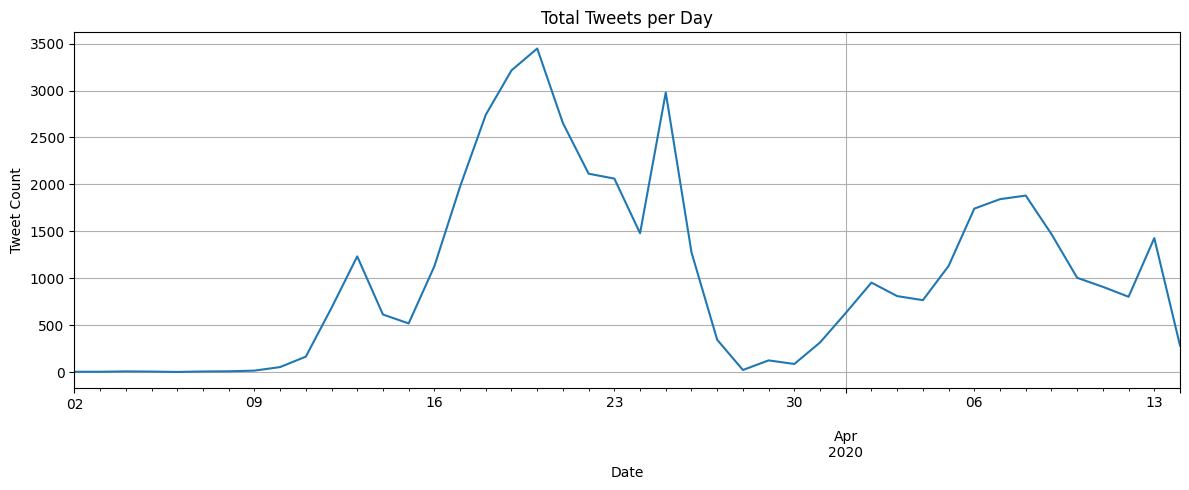

In [27]:
# Daily volume
tweets_per_day = combined_df.groupby('TweetAt').size()

tweets_per_day.plot(figsize=(12, 5), title='Total Tweets per Day')
plt.ylabel('Tweet Count')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


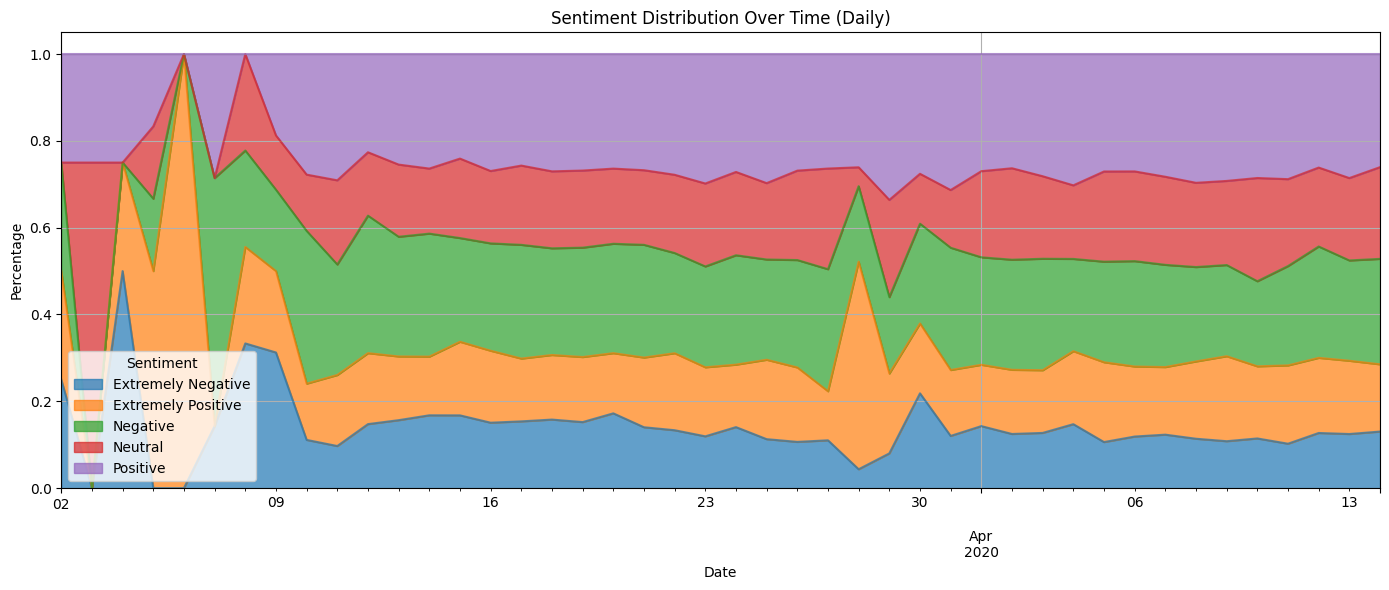

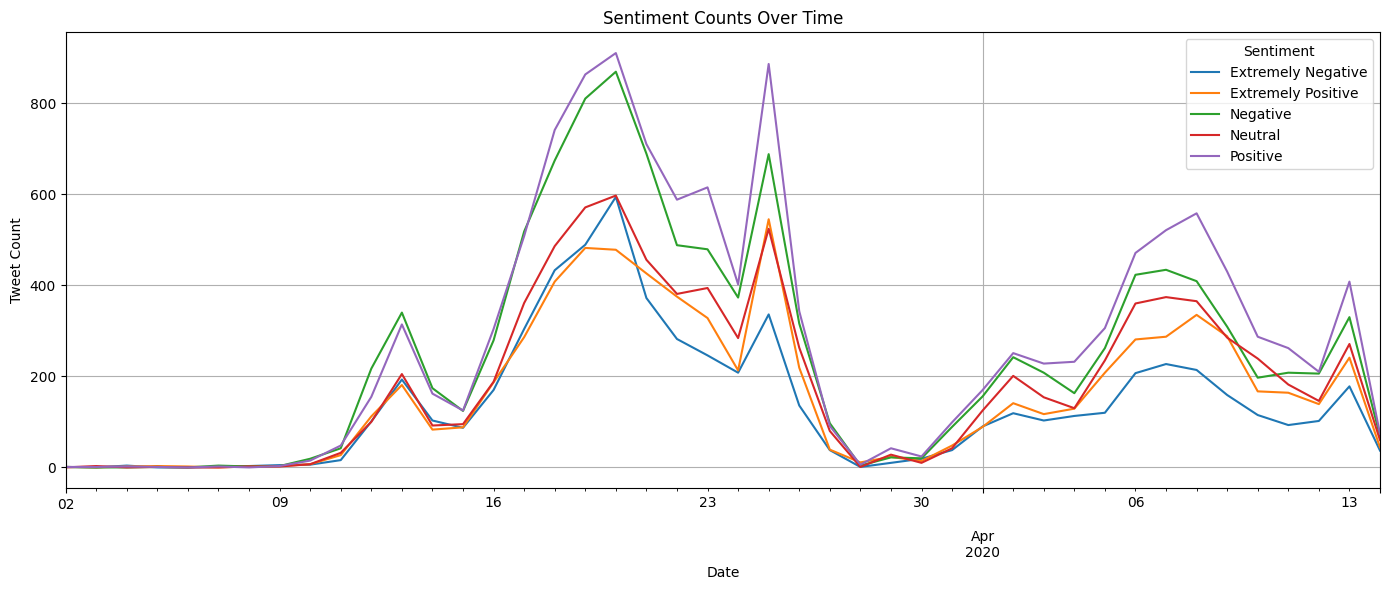

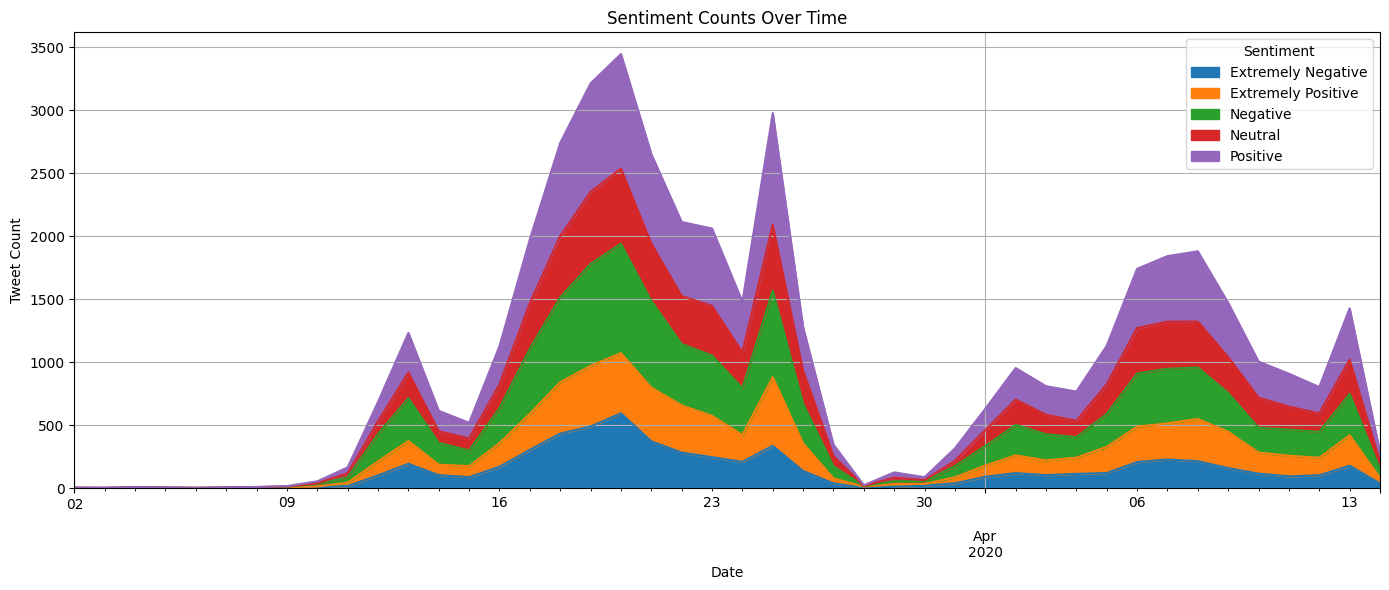

In [28]:
#Sentiment distribution
sentiment_daily = combined_df.groupby(['TweetAt', 'Sentiment']).size().unstack(fill_value=0)
sentiment_daily_pct = sentiment_daily.div(sentiment_daily.sum(axis=1), axis=0)

sentiment_daily_pct.plot.area(figsize=(14, 6), title='Sentiment Distribution Over Time (Daily)', alpha=0.7)
plt.ylabel('Percentage')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

sentiment_daily.plot(figsize=(14, 6), title='Sentiment Counts Over Time')
plt.ylabel('Tweet Count')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

sentiment_daily.plot(kind='area', figsize=(14, 6), title='Sentiment Counts Over Time')
plt.ylabel('Tweet Count')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


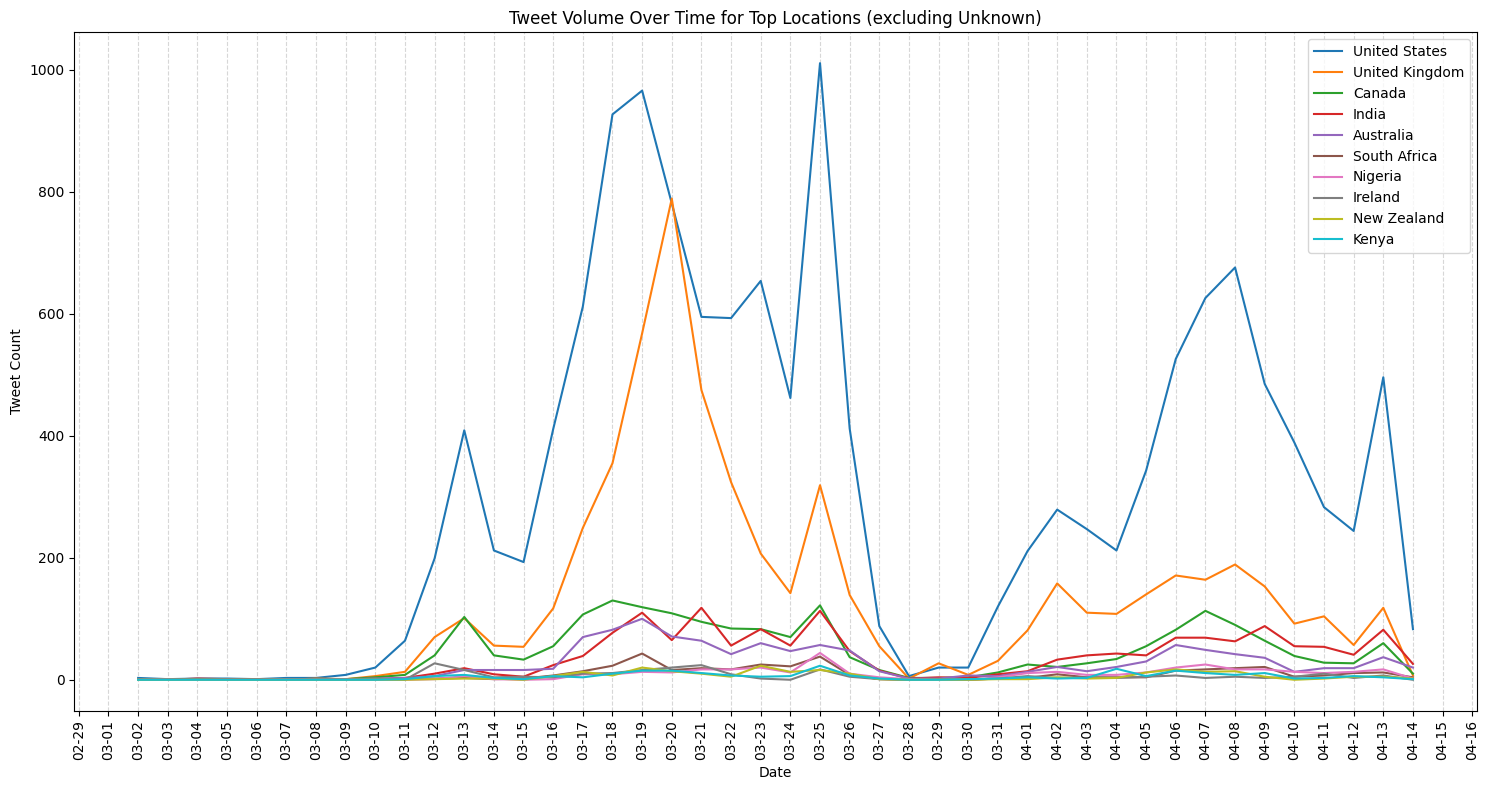

In [29]:
# Group by Location and Date, count tweets
location_daily = combined_df.groupby(['Location_standardized', 'TweetAt']).size().unstack(fill_value=0)

# Exclude 'unknown' from the location index
filtered_locations = location_daily.index[location_daily.index.str.lower() != 'unknown']

# Select top N locations excluding 'unknown'
top_locations = location_daily.loc[filtered_locations].sum(axis=1).sort_values(ascending=False).head(10).index


plt.figure(figsize=(15, 8))
for loc in top_locations:
    counts = location_daily.loc[loc]
    plt.plot(counts.index, counts.values, label=loc)

plt.title('Tweet Volume Over Time for Top Locations (excluding Unknown)')
plt.xlabel('Date')
plt.ylabel('Tweet Count')

ax = plt.gca()

# Set major ticks to every day
ax.xaxis.set_major_locator(mdates.DayLocator())

# Format the ticks as 'MM-DD' to save space
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Rotate for better readability
plt.xticks(rotation=90)

plt.legend()
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()





### Tweet content analysis

In [30]:
combined_df[['OriginalTweet']].head(10)

,OriginalTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P"
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j"
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n"
5,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU"
6,"Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented ""I'm in Civics class so I know what I'm talking about"". https://t.co/ieFDNeHgDO"
7,Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ
8,"Due to COVID-19 our retail store and classroom in Atlanta will not be open for walk-in business or classes for the next two weeks, beginning Monday, March 16. We will continue to process online and phone orders as normal! Thank you for your understanding! https://t.co/kw91zJ5O5i"
9,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona"


#### Tweets length

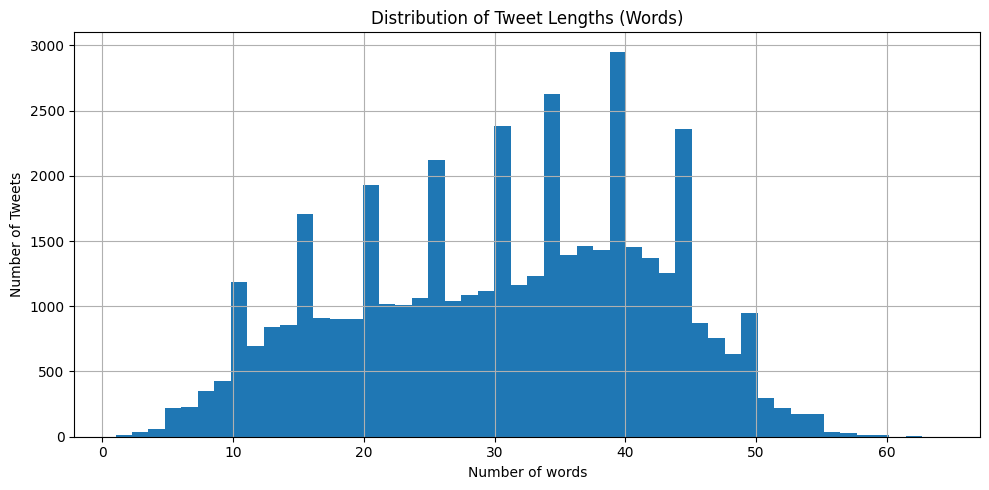

In [31]:
df_temp = combined_df.copy()
df_temp['tweet_length_word'] = df_temp['OriginalTweet'].str.split().apply(len)

plt.figure(figsize=(10,5))
df_temp['tweet_length_word'].hist(bins=50)
plt.title('Distribution of Tweet Lengths (Words)')
plt.xlabel('Number of words')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.tight_layout()
plt.show()




In [32]:
sentiment_map = {
    'Extremely Negative': -2,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Extremely Positive': 2
}

df_temp['sentiment_score'] = df_temp['Sentiment'].map(sentiment_map)

# Correlation
correlation = df_temp['tweet_length_word'].corr(df_temp['sentiment_score'])
print(f"Correlation between tweet length and sentiment score: {correlation:.3f}")


Correlation between tweet length and sentiment score: 0.025


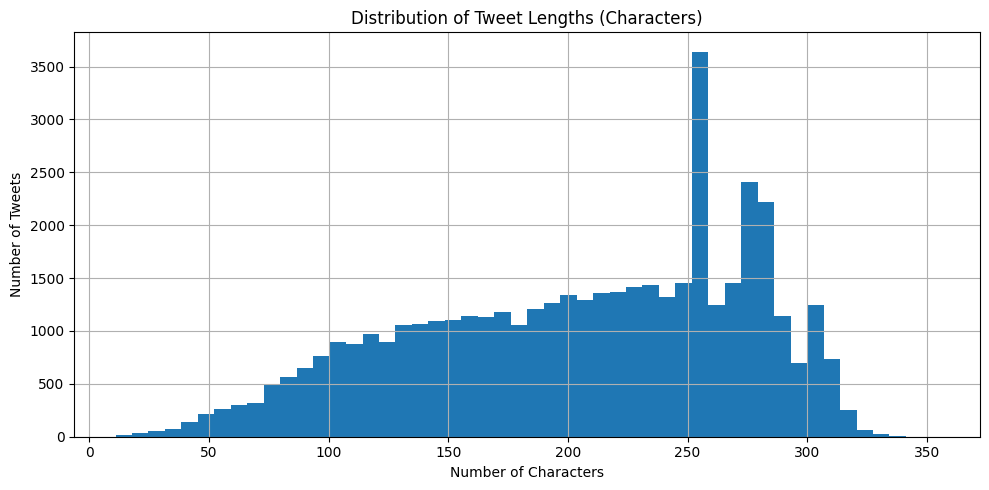

In [33]:
df_temp['tweet_length_char'] = df_temp['OriginalTweet'].str.len()

plt.figure(figsize=(10,5))
df_temp['tweet_length_char'].hist(bins=50)
plt.title('Distribution of Tweet Lengths (Characters)')
plt.xlabel('Number of Characters')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.tight_layout()
plt.show()


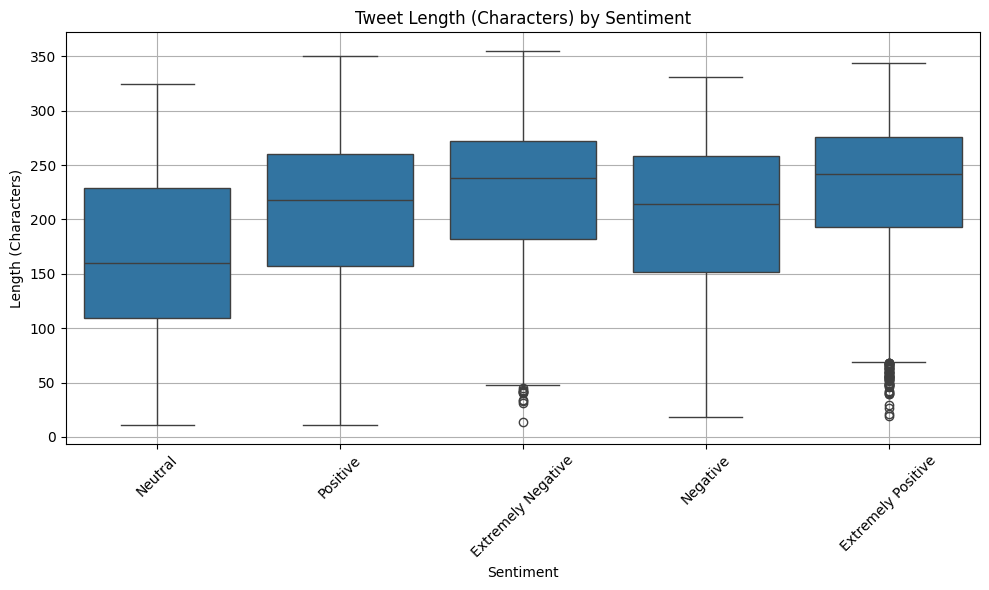

In [34]:
df_temp.groupby('Sentiment')['tweet_length_char'].mean().sort_values(ascending=False)


plt.figure(figsize=(10,6))
sns.boxplot(data=df_temp, x='Sentiment', y='tweet_length_char')
plt.title('Tweet Length (Characters) by Sentiment')
plt.ylabel('Length (Characters)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
sentiment_map = {
    'Extremely Negative': -2,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Extremely Positive': 2
}

df_temp['sentiment_score'] = df_temp['Sentiment'].map(sentiment_map)

# Correlation
correlation = df_temp['tweet_length_char'].corr(df_temp['sentiment_score'])
print(f"Correlation between tweet length and sentiment score: {correlation:.3f}")


Correlation between tweet length and sentiment score: 0.044


#### Emojis

In [36]:
## check if there are emojis in the tweets

df_temp = combined_df.copy()
def contains_emoji(text):
    return any(char in emoji.EMOJI_DATA for char in text)

# search for emoji in every tweet
df_temp['has_emoji'] = df_temp['OriginalTweet'].apply(contains_emoji)

# See how many tweets contain emojis
print(df_temp['has_emoji'].value_counts())

def extract_emojis(text):
    return ''.join(char for char in text if char in emoji.EMOJI_DATA)

#extract the emoji from every tweet
df_temp['emojis'] = df_temp['OriginalTweet'].apply(extract_emojis)


# show all different emojies
df_temp[df_temp.has_emoji].emojis.unique()


False    44900
True        55
Name: has_emoji, dtype: int64


array(['©', '©©©', '©©', '©©©©', '®', '®©'], dtype=object)

#### @user mentions analysis

In [37]:

# Function to extract all @user mentions from a tweet
def extract_mentions(text):
    return re.findall(r'@\w+', text)

# Create a new column with list of mentions
df_temp = combined_df.copy()
df_temp['mentions'] = df_temp['OriginalTweet'].apply(extract_mentions)
df_temp['mention_count'] = df_temp['mentions'].apply(len)

print("number of tweets with mentions:")
print(df_temp[df_temp['mentions'].apply(lambda x: len(x) > 0)].shape[0])


# Filter only tweets that have at least one mention
tweets_with_mentions = df_temp[df_temp['mention_count'] > 0]

# Group by sentiment and calculate average mention count
mention_stats = tweets_with_mentions.groupby('Sentiment')['mention_count'].mean().sort_values(ascending=False)
print("\navg number of mentions per sentiment")
print(mention_stats)



number of tweets with mentions:
10542

avg number of mentions per sentiment
Sentiment
Neutral               1.922652
Positive              1.793242
Negative              1.753864
Extremely Positive    1.738328
Extremely Negative    1.684692
Name: mention_count, dtype: float64


#### Hashtags analysis

In [38]:

def extract_hashtags(text):
    return re.findall(r'#\w+', text)

df_temp = combined_df.copy()
df_temp['hashtags'] = df_temp['OriginalTweet'].apply(extract_hashtags)
df_temp['hashtag_count'] = df_temp['hashtags'].apply(len)

print("number of tweets with hashtag:")
print(df_temp[df_temp['hashtags'].apply(lambda x: len(x) > 0)].shape[0])

# Filter only tweets that have at least one hashtag
tweets_with_hashtags = df_temp[df_temp['hashtag_count'] > 0]

# Group by sentiment and calculate average hashtag count
mention_stats = tweets_with_hashtags.groupby('Sentiment')['hashtag_count'].mean().sort_values(ascending=False)
print("\navg number of hashtags per sentiment")
print(mention_stats)



number of tweets with hashtag:
26624

avg number of hashtags per sentiment
Sentiment
Neutral               4.042245
Positive              3.295455
Extremely Positive    3.265621
Negative              3.162112
Extremely Negative    2.806977
Name: hashtag_count, dtype: float64


#### URL extraction

In [39]:

def extract_urls(text):
    return re.findall(r'http\S+', text)

combined_df['urls'] = combined_df['OriginalTweet'].apply(extract_urls)

#### clean data

In [40]:


def clean_tweet(text):
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove newline, return, tab characters
    text = re.sub(r'[\r\n\t]+', ' ', text)
    
    # Unescape HTML entities (e.g., &amp; → &)
    text = html.unescape(text)
    
    # Remove bad encoding characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # remove non-ASCII
    text = text.replace('â€”', '-')  # common encoding artifact

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

combined_df['clean_tweet'] = combined_df['OriginalTweet'].apply(clean_tweet)


#### langauage detection

In [41]:


# Ensure reproducibility
DetectorFactory.seed = 42

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'
df_temp = combined_df.copy()
df_temp['language'] = df_temp['OriginalTweet'].apply(detect_language)


In [42]:
df_temp.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Location_standardized,urls,clean_tweet,language
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,United Kingdom,"[https://t.co/iFz9FAn2Pa, https://t.co/xX6ghGFzCC, https://t.co/I2NlzdxNo8]",and and,en
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,United Kingdom,[],advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,en
2,3801,48753,Vagabonds,2020-03-16,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,unknown,[https://t.co/bInCA9Vp8P],"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak",en
3,3802,48754,Unknown,2020-03-16,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive,unknown,[https://t.co/zrlG0Z520j],"My food stock is not the only one which is empty... PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. Stay calm, stay safe. #COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral",en
4,3803,48755,Unknown,2020-03-16,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative,unknown,[https://t.co/usmuaLq72n],"Me, ready to go at supermarket during the #COVID19 outbreak. Not because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage... #CoronavirusFrance #restezchezvous #StayAtHome #confinement",en


In [43]:
print(df_temp['language'].value_counts())


en         44723
fr            34
es            26
de            26
it            18
unknown       14
no            14
id            13
ca            12
af            10
ro            10
da             7
tl             7
nl             7
tr             5
et             5
sv             4
sw             3
pt             3
sk             2
pl             2
cy             2
vi             2
fi             2
lt             1
sl             1
so             1
cs             1
Name: language, dtype: int64


#### Word Cloud

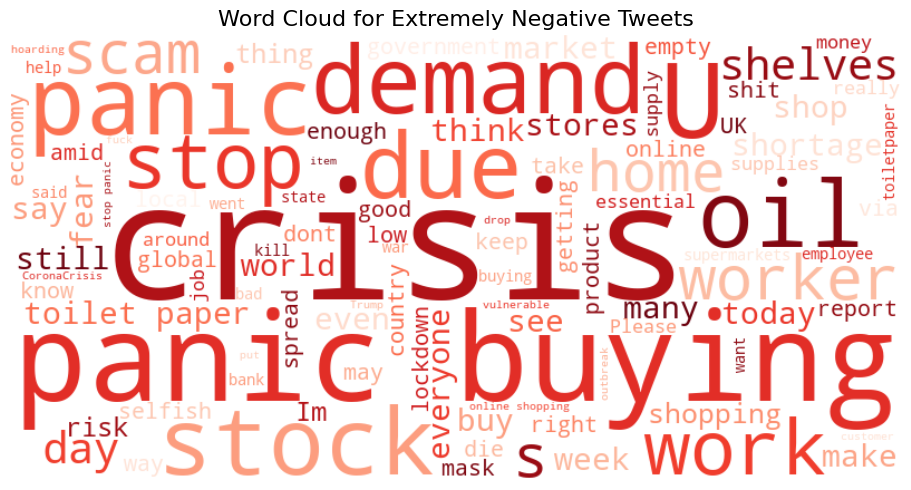

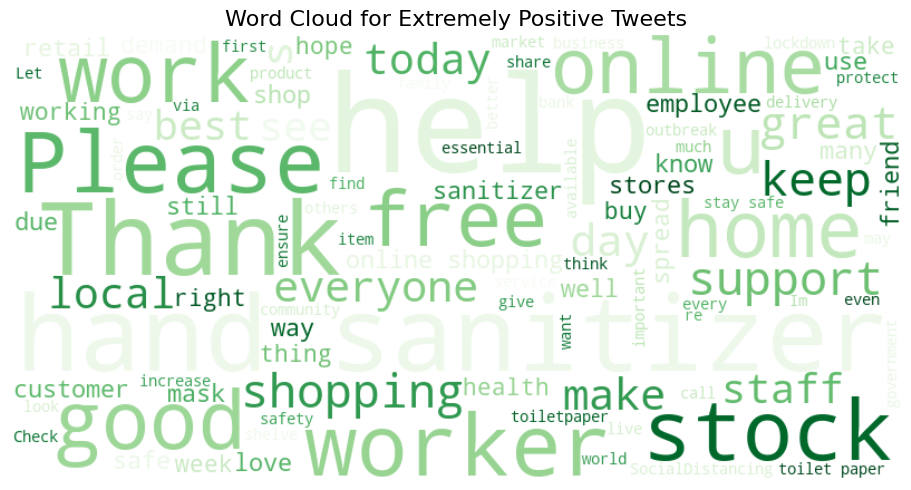

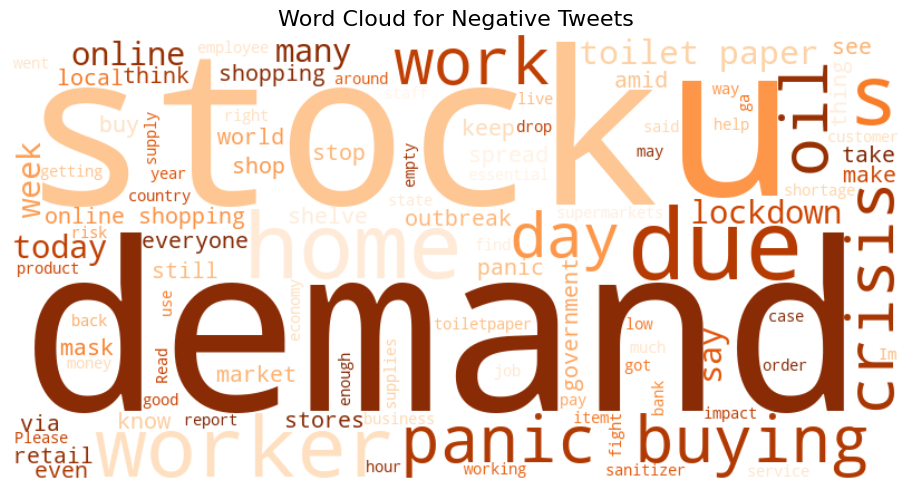

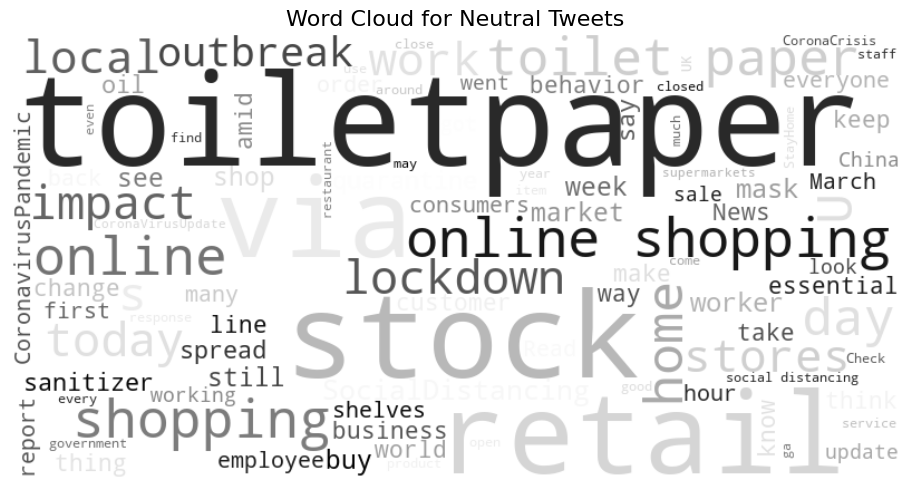

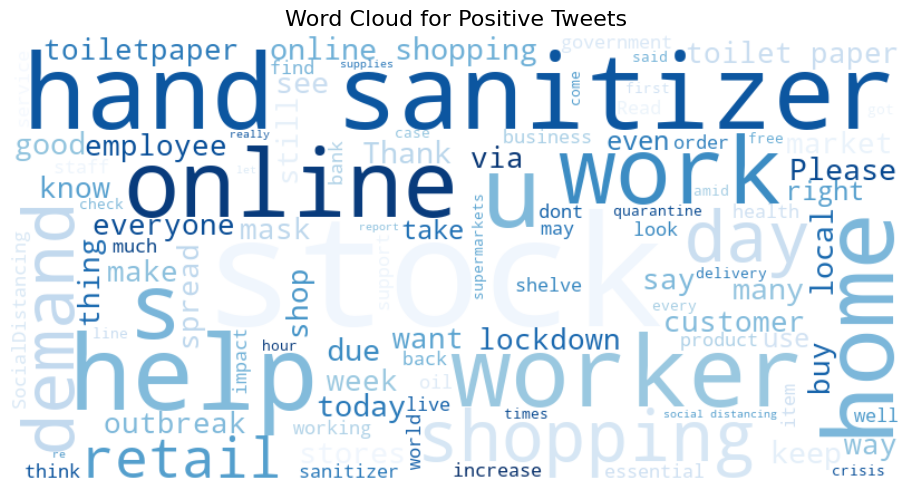

In [44]:

# Group tweets by sentiment and concatenate text
sentiment_texts = combined_df.groupby('Sentiment')['clean_tweet'].apply(lambda x: ' '.join(x)).to_dict()

# add to stopwords word that are rellay popular among all sentiments
custom_stopwords = set([
    'covid', 'covid19', 'coronavirus', 'virus', 'corona',  'rt', 'amp', 'pandemic',
    'covid_19', 'covid19france', 'covid19uk', 'covidー19', 'covid19us', 'covid2019', 'supermarket', 'people', 'grocery', 'store', 'food',
    'will', 'price', 'prices', 'consumer', 'need', 'time', 'now', 'go', 'going', 'new', 'one'

])
all_stopwords = STOPWORDS.union(custom_stopwords)

sentiment_colormaps = {
    'Extremely Negative': 'Reds',
    'Negative': 'Oranges',
    'Neutral': 'Greys',
    'Positive': 'Blues',
    'Extremely Positive': 'Greens'
}

for sentiment, text in sentiment_texts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, stopwords=all_stopwords
                          ,colormap=sentiment_colormaps.get(sentiment, 'viridis')).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {sentiment} Tweets", fontsize=16)
    plt.tight_layout()
    plt.show()



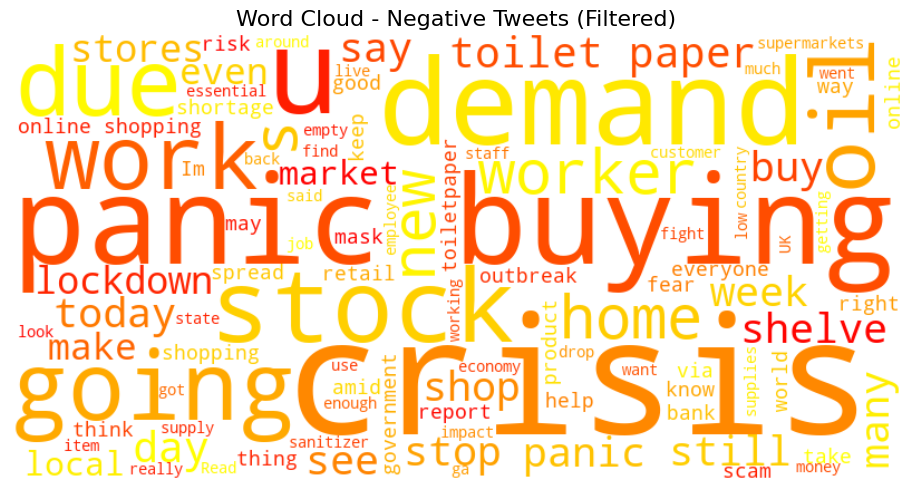

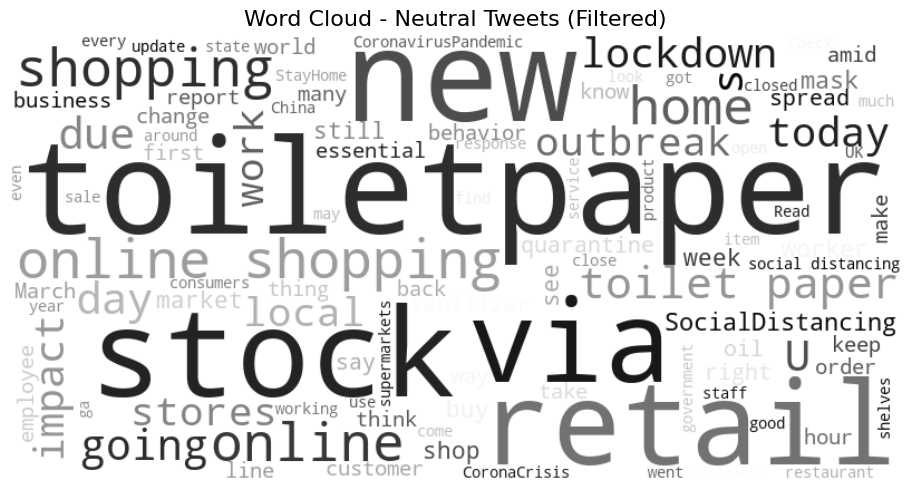

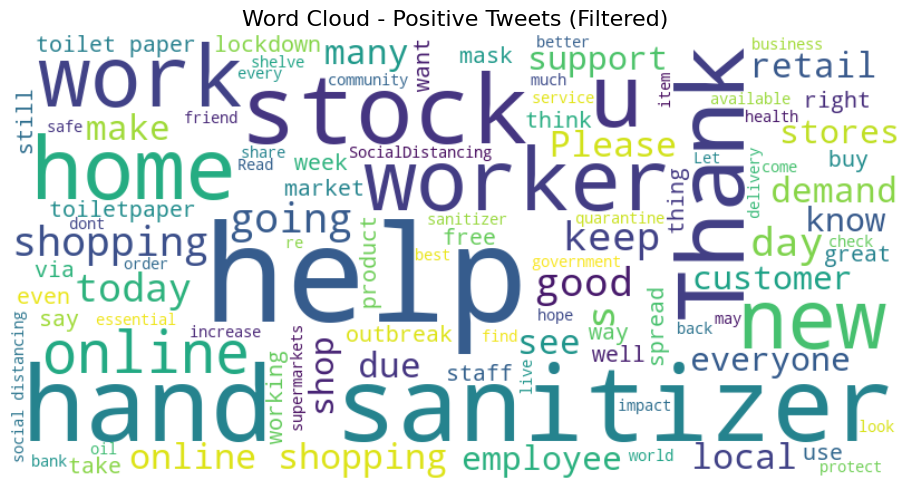

In [45]:


# Create grouped sentiment column
def map_sentiment_group(sentiment):
    if sentiment in ['Positive', 'Extremely Positive']:
        return 'Positive'
    elif sentiment in ['Negative', 'Extremely Negative']:
        return 'Negative'
    else:
        return 'Neutral'

temp_df = combined_df.copy()
temp_df['Sentiment_Grouped'] = temp_df['Sentiment'].apply(map_sentiment_group)

# Group clean tweets by grouped sentiment
grouped_texts = temp_df.groupby('Sentiment_Grouped')['clean_tweet'].apply(lambda x: ' '.join(x)).to_dict()

# Define custom stopwords (standard + COVID-related and popular terms)
custom_stopwords = set([
    'covid', 'covid19', 'coronavirus', 'virus', 'corona',  'rt', 'amp', 'pandemic',
    'covid_19', 'covid19france', 'covid19uk', 'covidー19', 'covid19us', 'covid2019', 'supermarket', 'people', 'grocery', 'store', 'food',
    'will', 'price', 'prices', 'consumer', 'need', 'time', 'now', 'go', 'going' 'new', 'one'


])
all_stopwords = STOPWORDS.union(custom_stopwords)

# Generate and plot word clouds per sentiment group
for sentiment_group, text in grouped_texts.items():
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        stopwords=all_stopwords,
        colormap='viridis' if sentiment_group == 'Positive' else 'autumn' if sentiment_group == 'Negative' else 'gray'
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {sentiment_group} Tweets (Filtered)", fontsize=16)
    plt.tight_layout()
    plt.show()


### Train - Test comparison:

In [46]:
def compare_train_test_distributions(train_df, test_df, 
                                   text_column='OriginalTweet', 
                                   sentiment_column='Sentiment',
                                   location_column='Location',
                                   date_column='TweetAt',
                                   date_format='%d-%m-%Y'):
    
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()
    
    ## Label distribution comparison: 
    print("Train - Test sentiment distribution comparison:")
    train_sentiment = train_df_copy['Sentiment'].value_counts(normalize=True).sort_index()
    test_sentiment = test_df_copy['Sentiment'].value_counts(normalize=True).sort_index()

    comparison_df = pd.DataFrame({
        'Train': train_sentiment,
        'Test': test_sentiment,
        'Difference': train_sentiment - test_sentiment
    })
    print(comparison_df)
    # Visualize
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    comparison_df[['Train', 'Test']].plot(kind='bar', ax=ax)
    plt.title('Sentiment Distribution: Train vs Test')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    ## tweet length distribution comparison
    for df in [train_df_copy, test_df_copy]:
        df['tweet_length'] = df['OriginalTweet'].str.len()
        df['word_count'] = df['OriginalTweet'].str.split().str.len()

    # Statistical comparison
    print("Text length statistics comparison:")
    features = ['tweet_length', 'word_count']
    for feature in features:
        print(f"\n{feature}:")
        print(f"Train: mean={train_df_copy[feature].mean():.1f}, std={train_df_copy[feature].std():.1f}")
        print(f"Test:  mean={test_df_copy[feature].mean():.1f}, std={test_df_copy[feature].std():.1f}")

    # Visualize distributions
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i, feature in enumerate(features):
        axes[i].hist(train_df_copy[feature], alpha=0.7, label='Train', bins=50, density=True)
        axes[i].hist(test_df_copy[feature], alpha=0.7, label='Test', bins=50, density=True)
        axes[i].set_title(f'{feature} Distribution')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

    ## Location distribution comparison 
    print("Location distribution comparison:")
    # Top N locations in each
    top_n = 10
    top_train = train_df_copy['Location_standardized'].value_counts().head(top_n).index
    top_test = test_df_copy['Location_standardized'].value_counts().head(top_n).index
    # Union of both sets
    top_locations = sorted(set(top_train).union(set(top_test)))
    # Get normalized frequencies for just those locations
    train_freq = train_df_copy['Location_standardized'].value_counts(normalize=True).reindex(top_locations, fill_value=0)
    test_freq = test_df_copy['Location_standardized'].value_counts(normalize=True).reindex(top_locations, fill_value=0)
    # Combine for comparison
    comparison_df = pd.DataFrame({
        'Train': train_freq,
        'Test': test_freq
    })

    # Visualize
    comparison_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Location Distribution Comparison (Union of Top 10 in Train and Test)')
    plt.ylabel('Proportion of Tweets')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    ## Time range comparison:

    print("Time range comparison:")
    print(f"Train: {train_df_copy['TweetAt'].min()} to {train_df_copy['TweetAt'].max()}")
    print(f"Test:  {test_df_copy['TweetAt'].min()} to {test_df_copy['TweetAt'].max()}")

    print(f"\nTrain time span: {(train_df_copy['TweetAt'].max() - train_df_copy['TweetAt'].min()).days} days")
    print(f"Test time span:  {(test_df_copy['TweetAt'].max() - test_df_copy['TweetAt'].min()).days} days")


Train - Test sentiment distribution comparison:
                       Train      Test  Difference
Extremely Negative  0.133173  0.155872   -0.022699
Extremely Positive  0.160945  0.157715    0.003230
Negative            0.240955  0.274092   -0.033136
Neutral             0.187404  0.162981    0.024424
Positive            0.277523  0.249342    0.028181


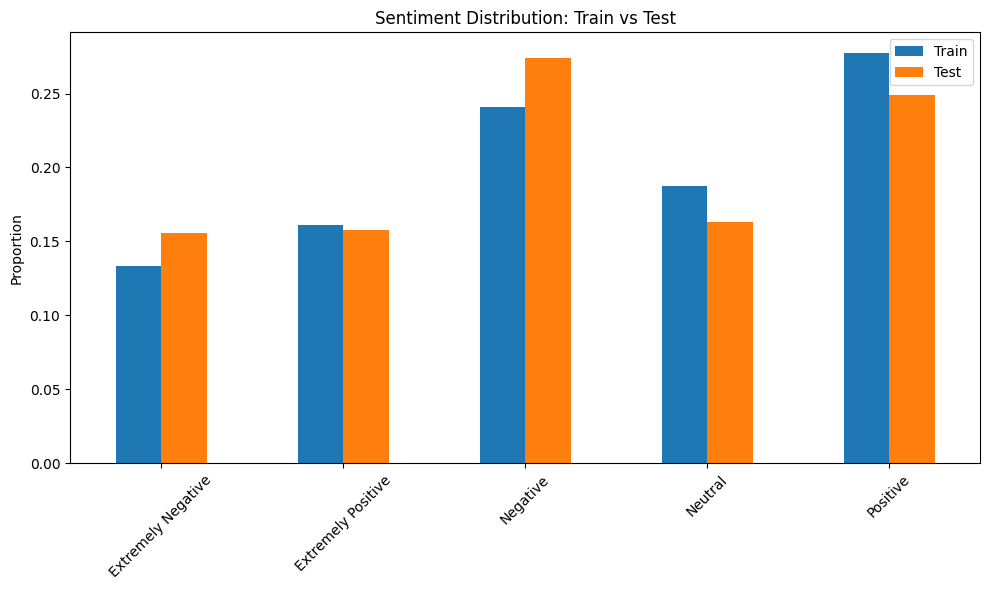

Text length statistics comparison:

tweet_length:
Train: mean=204.2, std=68.7
Test:  mean=213.9, std=66.7

word_count:
Train: mean=30.5, std=11.6
Test:  mean=32.9, std=11.8


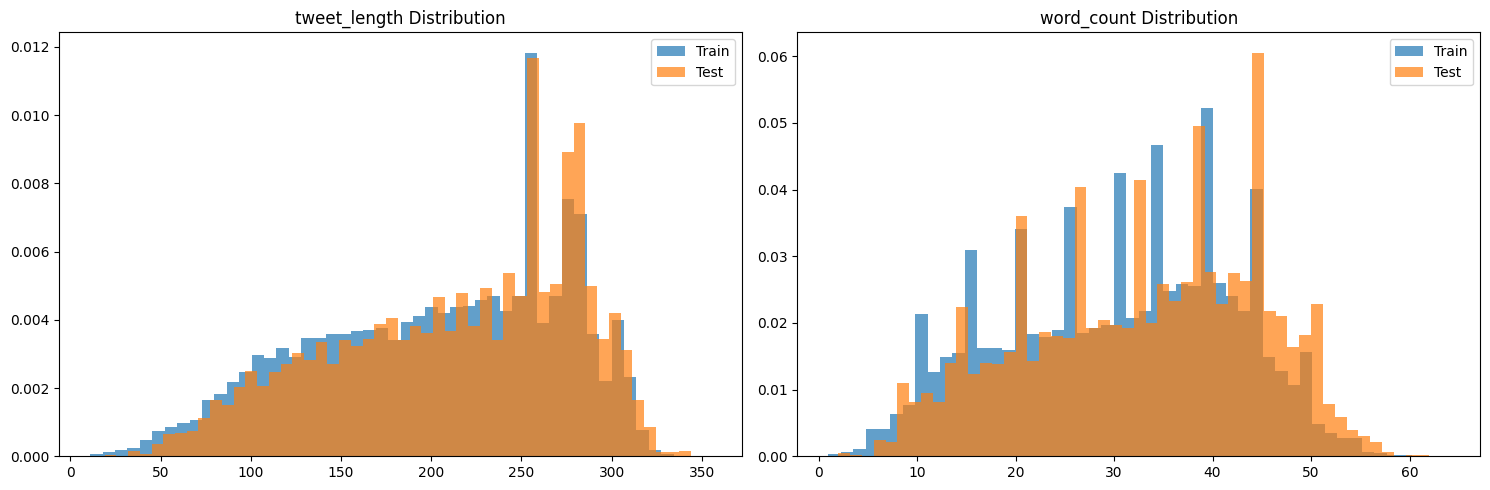

Location distribution comparison:


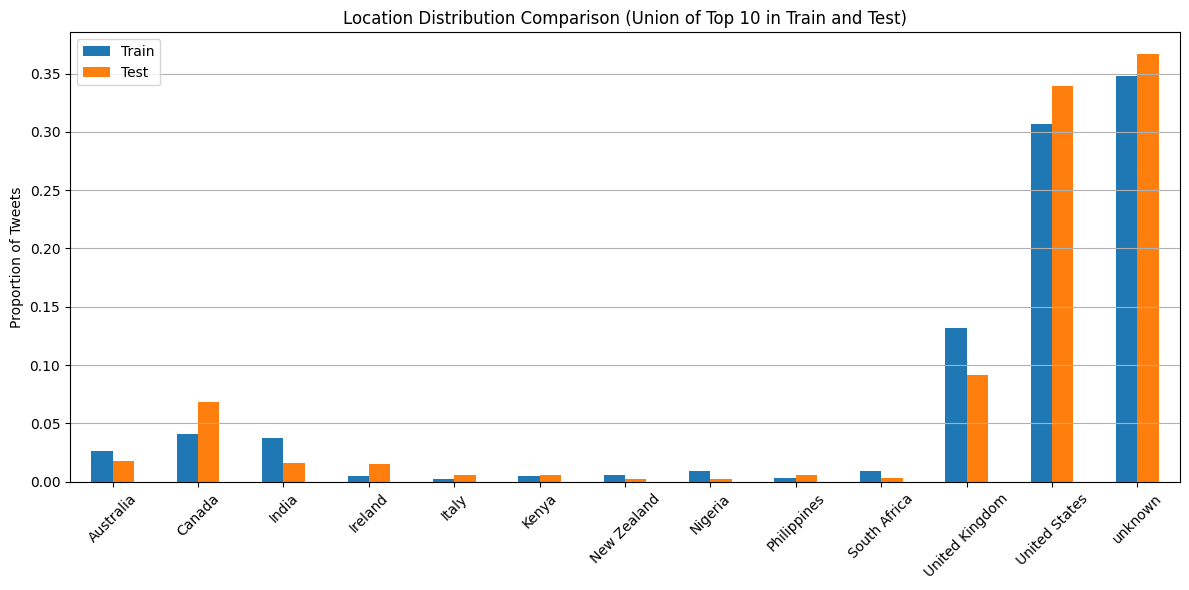

Time range comparison:
Train: 2020-03-16 00:00:00 to 2020-04-14 00:00:00
Test:  2020-03-02 00:00:00 to 2020-03-16 00:00:00

Train time span: 29 days
Test time span:  14 days


In [47]:
compare_train_test_distributions(train, test)


### split to new OOT train and test

In [49]:
combined_df_temp = combined_df.sort_values('TweetAt').reset_index(drop=True).copy()

# Calculate split point (80% of total records)
split_index_train_test = int(len(combined_df_temp) * 0.8)
best_split_date = combined_df_temp.iloc[[split_index_train_test]]['TweetAt'].values[0]

OOT_train = combined_df_temp[combined_df_temp['TweetAt'] <= best_split_date]
OOT_val_test = combined_df_temp[combined_df_temp['TweetAt'] > best_split_date]


In [51]:
print("Dataset shapes:")
print(f"Train: {OOT_train.shape}")
print(f"Test: {OOT_val_test.shape}")

Dataset shapes:
Train: (37174, 9)
Test: (7781, 9)


### new train and val+test comparison

Train - Test sentiment distribution comparison:
                       Train      Test  Difference
Extremely Negative  0.139210  0.115409    0.023801
Extremely Positive  0.157234  0.177098   -0.019865
Negative            0.248292  0.222079    0.026212
Neutral             0.182493  0.198946   -0.016453
Positive            0.272771  0.286467   -0.013696


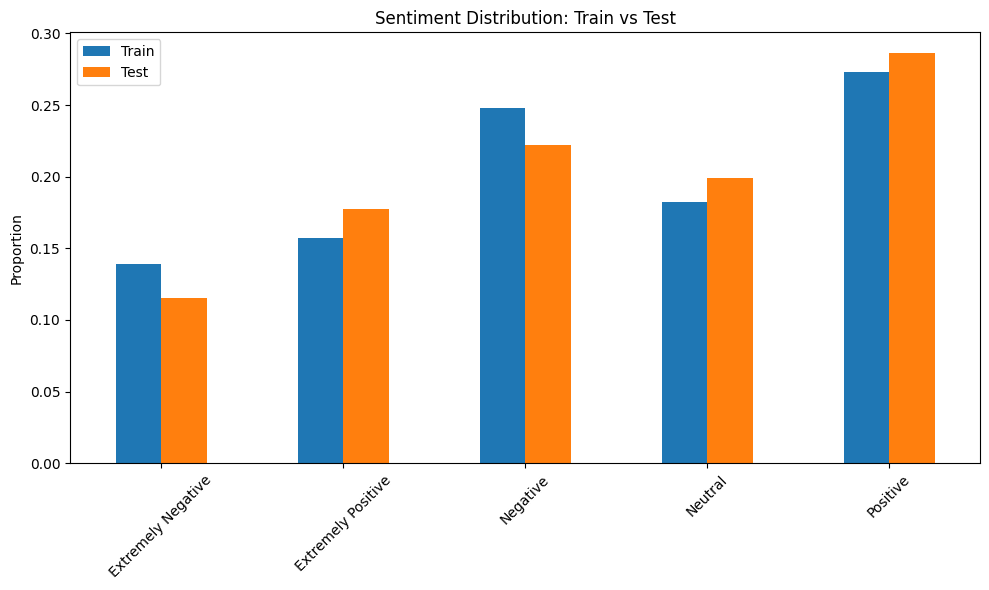

Text length statistics comparison:

tweet_length:
Train: mean=205.8, std=68.2
Test:  mean=201.4, std=69.9

word_count:
Train: mean=30.9, std=11.7
Test:  mean=29.5, std=11.4


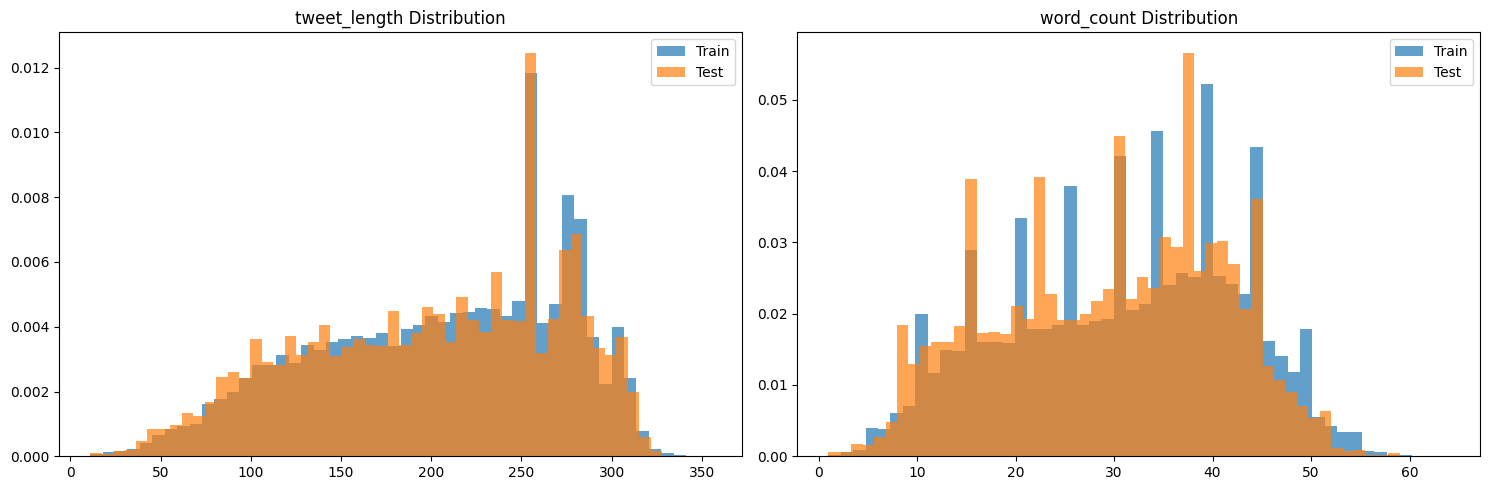

Location distribution comparison:


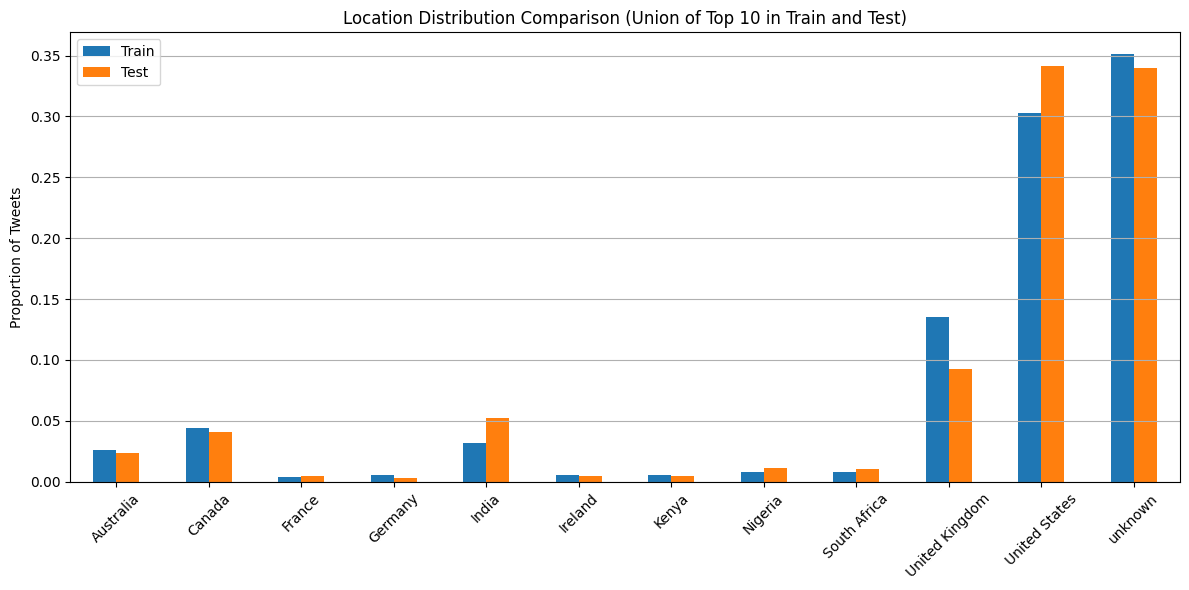

Time range comparison:
Train: 2020-03-02 00:00:00 to 2020-04-07 00:00:00
Test:  2020-04-08 00:00:00 to 2020-04-14 00:00:00

Train time span: 36 days
Test time span:  6 days


In [52]:
compare_train_test_distributions(OOT_train, OOT_val_test)


#### create validation dataset

In [55]:

# Calculate split point (80% of total records)
split_index_val_test = int(len(OOT_val_test) * 0.5)
best_split_date = OOT_val_test.iloc[[split_index_val_test]]['TweetAt'].values[0]

OOT_val = OOT_val_test[OOT_val_test['TweetAt'] <= best_split_date]
OOT_test = OOT_val_test[OOT_val_test['TweetAt'] > best_split_date]

In [56]:
print("Dataset shapes:")
print(f"val: {OOT_val.shape}")
print(f"Test: {OOT_test.shape}")

Dataset shapes:
val: (4357, 9)
Test: (3424, 9)


### save new datasets

In [57]:
OOT_train_clean = OOT_train[['TweetAt', 'Location_standardized', 'urls', 'clean_tweet', 'Sentiment']].copy()
OOT_val_clean = OOT_val[['TweetAt', 'Location_standardized', 'urls', 'clean_tweet', 'Sentiment']].copy()
OOT_test_clean = OOT_test[['TweetAt', 'Location_standardized', 'urls', 'clean_tweet', 'Sentiment']].copy()

In [58]:
# Save to CSV
OOT_train_clean.to_csv("OOT_train.csv", index = False)
OOT_val_clean.to_csv("OOT_val.csv", index = False)
OOT_test_clean.to_csv("OOT_test.csv", index = False)